# EDA - CriptoRisk

In [391]:
import pandas as pd
import json
import requests
import os
import pandas as pd
import datetime
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter

Probamos la API de CoinGecko

In [392]:
api_url = 'https://api.coingecko.com/api/v3/'

reqlista = "/global"
res = requests.get(api_url + reqlista)

lista = pd.read_json(res.text)
lista.head(20)

,data
active_cryptocurrencies,10214
ended_icos,3376
market_cap_change_percentage_24h_usd,-0.153266
market_cap_percentage,"{'btc': 46.38948106496677, 'eth': 18.179560771..."
markets,838
ongoing_icos,49
total_market_cap,"{'btc': 41966046.08000683, 'eth': 661268484.22..."
total_volume,"{'btc': 1284620.2007919024, 'eth': 20242051.18..."
upcoming_icos,0
updated_at,1693008991


Conocemos las 10 monedas que mayor Market Cap poseen (capitalización en el mercado)

In [393]:
df = lista.loc["market_cap_percentage", "data"]

pdTop = pd.DataFrame([[key, df[key]] for key in df.keys()], columns=["token", "porcentaje"])
pdTop

,token,porcentaje
0,btc,46.389481
1,eth,18.179561
2,usdt,7.575829
3,bnb,3.072685
4,xrp,2.541739
5,usdc,2.375243
6,steth,1.267058
7,ada,0.835543
8,doge,0.811282
9,sol,0.759164


Las 10 monedas que mas market cap poseen, son

In [394]:
pdTop.iloc[:,0].values

array(['btc', 'eth', 'usdt', 'bnb', 'xrp', 'usdc', 'steth', 'ada', 'doge',
       'sol'], dtype=object)

Conocemos los nombres validos para luego solicitar las cotizaciones. Necesitamos los ids

In [395]:
reqlista = "/coins/list"
res = requests.get(api_url + reqlista)


lista = pd.read_json(res.text)
lista.head(5)

,id,symbol,name
0,01coin,zoc,01coin
1,0chain,zcn,Zus
2,0vix-protocol,vix,0VIX Protocol
3,0x,zrx,0x Protocol
4,0x0-ai-ai-smart-contract,0x0,0x0.ai: AI Smart Contract


En la siguiente linea vemos que cada una de las monedas se encuentra listada de manera nativa y en diversos mercados / exchanges / o de manera que replica a la moneda original. Ejemplo, el token bnb se encuentra de manera nativa, y a su vez se encuentra en OEX Binance Coin, Binance Coin (wormhole) y Heco-Peg Binance Coin. 

In [396]:
listadf = lista
tokens_to_filter = ['btc', 'eth', 'usdt', 'bnb', 'xrp', 'usdc', 'steth', 'ada', 'doge','sol']
filtered_df = listadf[listadf['symbol'].isin(tokens_to_filter)]
filtered_df.head(20)

,id,symbol,name
1110,binancecoin,bnb,BNB
1111,binance-coin-wormhole,bnb,Binance Coin (Wormhole)
1117,binance-peg-cardano,ada,Binance-Peg Cardano
1118,binance-peg-dogecoin,doge,Binance-Peg Dogecoin
1126,binance-peg-xrp,xrp,Binance-Peg XRP
1165,bitcoin,btc,Bitcoin
1473,bridged-tether-linea,usdt,Bridged Tether (Linea)
1474,bridged-tether-stargate,usdt,Bridged Tether (Stargate)
1478,bridged-usd-coin-linea,usdc,Bridged USD Coin (Linea)
1638,cardano,ada,Cardano


In [397]:
def precios(symbol):
    url = "https://api.coingecko.com/api/v3/coins/"+symbol+"/market_chart?vs_currency=usd&days=max&interval=daily"
    r = requests.get(url)
    js = r.json()
    df = pd.DataFrame(js)
    df = pd.DataFrame(df["prices"])
    columnas = df["prices"].apply(pd.Series)
    columnas.columns = ["timestamp", symbol]
    df_sep = pd.concat([df, columnas], axis=1)
    df_sep = df_sep.drop("prices", axis=1)
    df_sep["timestamp"] = pd.to_datetime(df_sep["timestamp"], unit="ms")
    return df_sep

In [398]:
data = precios("bitcoin")
data.head()

,timestamp,bitcoin
0,2013-04-28,135.30
1,2013-04-29,141.96
2,2013-04-30,135.30
3,2013-05-01,117.00
4,2013-05-02,103.43


## Data principal
Obtenemos las monedas que nos interesan para analizar. Recordamos, son las 10 que poseen mayor market cap

In [399]:
symbols = ["bitcoin", "ethereum", "binancecoin", "ripple", "usd-coin", "staked-ether", "dogecoin", "solana", "cardano", "tether"]  # Agrega más símbolos si es necesario

# Obtener los datos de Bitcoin como punto de partida
result_df = precios(symbols[0])

# Iterar sobre los símbolos (excluyendo Bitcoin) y agregar los valores dentro de las fechas existentes
for symbol in symbols[1:]:
    df = precios(symbol)
    df = df.rename(columns={"C": symbol})  # Renombrar la columna 'C' con el símbolo correspondiente
    result_df = pd.merge(result_df, df, on="timestamp", how="left")

In [400]:
result_df['date'] = result_df['timestamp'].astype(str).str.split(' ').str[0]
result_df = result_df.set_index('date')
result_df = result_df.drop(["timestamp"], axis=1)

In [401]:
result_df.head()

,bitcoin,ethereum,binancecoin,ripple,usd-coin,staked-ether,dogecoin,solana,cardano,tether
date,,,,,,,,,,
2013-04-28,135.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,141.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,135.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01,117.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-02,103.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Conocemos los valores faltantes

In [402]:
result_df.isnull().sum()

bitcoin            0
ethereum         835
binancecoin     1605
ripple           107
usd-coin        1985
staked-ether    2794
dogecoin         237
solana          2539
cardano         1635
tether           694
dtype: int64

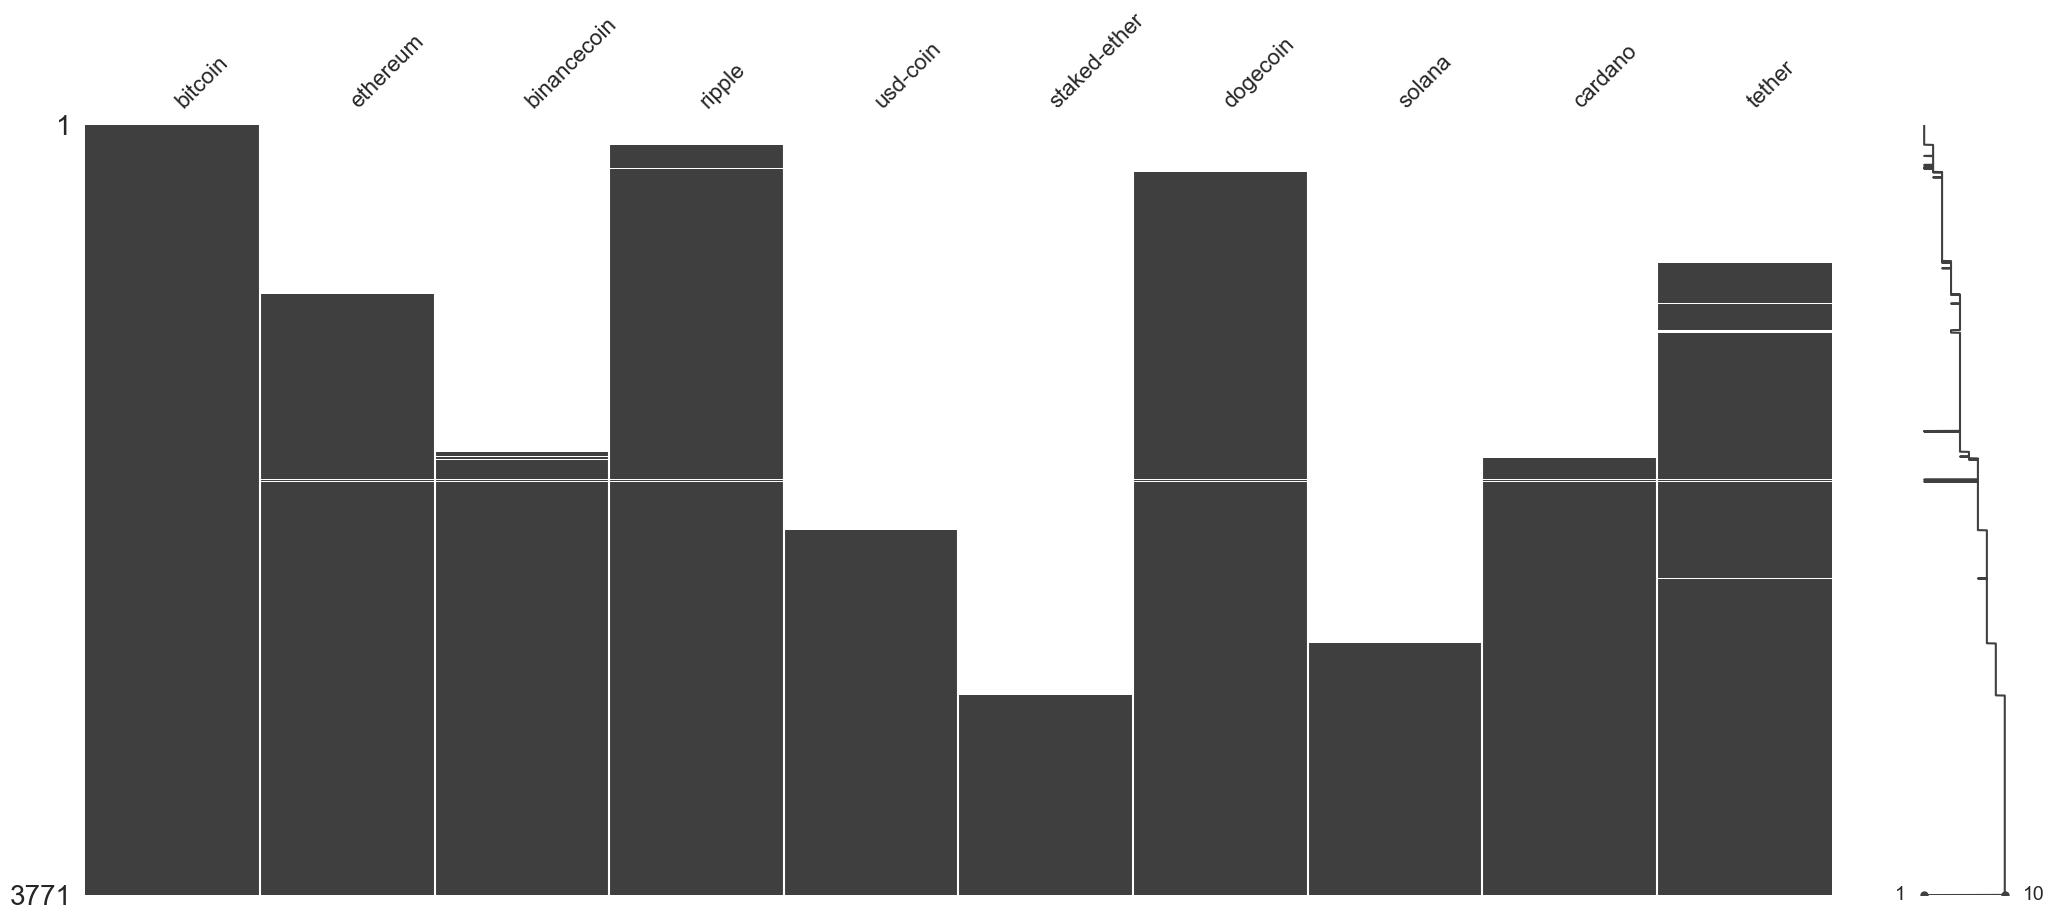

In [403]:
import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(result_df)
plt.show()

Conocemos donde comienzan a ofrecernos valores la moneda más reciente

In [404]:
nan_start_index = result_df["staked-ether"].first_valid_index()
nan_start_index

'2020-12-22'

In [405]:
result_df.loc["2020-12-20":"2020-12-30"]

,bitcoin,ethereum,binancecoin,ripple,usd-coin,staked-ether,dogecoin,solana,cardano,tether
date,,,,,,,,,,
2020-12-20,23863.854842,659.318808,33.285712,0.579158,0.999713,NaN,0.003925,1.668309,0.164726,0.998296
2020-12-21,23518.318421,639.515437,34.189929,0.560066,0.999370,NaN,0.004616,1.563348,0.162049,1.002810
2020-12-22,22840.991707,610.427028,32.303140,0.517176,0.996955,617.164997,0.004802,1.543421,0.153691,1.002030
2020-12-23,23794.793303,634.979723,33.509891,0.451321,1.002172,617.164997,0.004534,1.492884,0.157080,1.001962
2020-12-24,23308.127232,587.958895,31.298017,0.260507,1.002596,596.767711,0.003826,1.206243,0.138430,1.004013
2020-12-25,23760.287049,612.879657,32.496951,0.344804,1.002147,611.504712,0.004587,1.363459,0.152868,1.002383
2020-12-26,24671.107714,626.456739,33.157661,0.318084,1.000226,624.800420,0.004589,1.445885,0.157347,1.002936
2020-12-27,26476.130137,636.742317,33.512402,0.295383,1.001350,629.066656,0.004516,1.328261,0.158331,1.002081
2020-12-28,26423.228792,689.659857,33.497444,0.284147,0.998521,678.099141,0.004552,1.306540,0.154970,1.001305


Desde el 22-12-2020 tenemos valores en todas las columnas buscadas. Cortaremos los valores en dicha serie de tiempo, a los efectos del presente informe

In [406]:
df_informe = result_df.loc["2020-12-22":]
df_informe

,bitcoin,ethereum,binancecoin,ripple,usd-coin,staked-ether,dogecoin,solana,cardano,tether
date,,,,,,,,,,
2020-12-22,22840.991707,610.427028,32.303140,0.517176,0.996955,617.164997,0.004802,1.543421,0.153691,1.002030
2020-12-23,23794.793303,634.979723,33.509891,0.451321,1.002172,617.164997,0.004534,1.492884,0.157080,1.001962
2020-12-24,23308.127232,587.958895,31.298017,0.260507,1.002596,596.767711,0.003826,1.206243,0.138430,1.004013
2020-12-25,23760.287049,612.879657,32.496951,0.344804,1.002147,611.504712,0.004587,1.363459,0.152868,1.002383
2020-12-26,24671.107714,626.456739,33.157661,0.318084,1.000226,624.800420,0.004589,1.445885,0.157347,1.002936
...,...,...,...,...,...,...,...,...,...,...
2023-08-22,26119.005959,1666.840465,210.588285,0.524406,0.999317,1667.354058,0.062501,21.202109,0.262942,0.999832
2023-08-23,26033.675407,1635.191294,210.838317,0.520924,0.999795,1631.335095,0.062579,20.553892,0.258382,1.000200
2023-08-24,26450.008625,1679.123993,216.469337,0.529919,1.000291,1678.287698,0.063823,21.672559,0.268273,1.001008


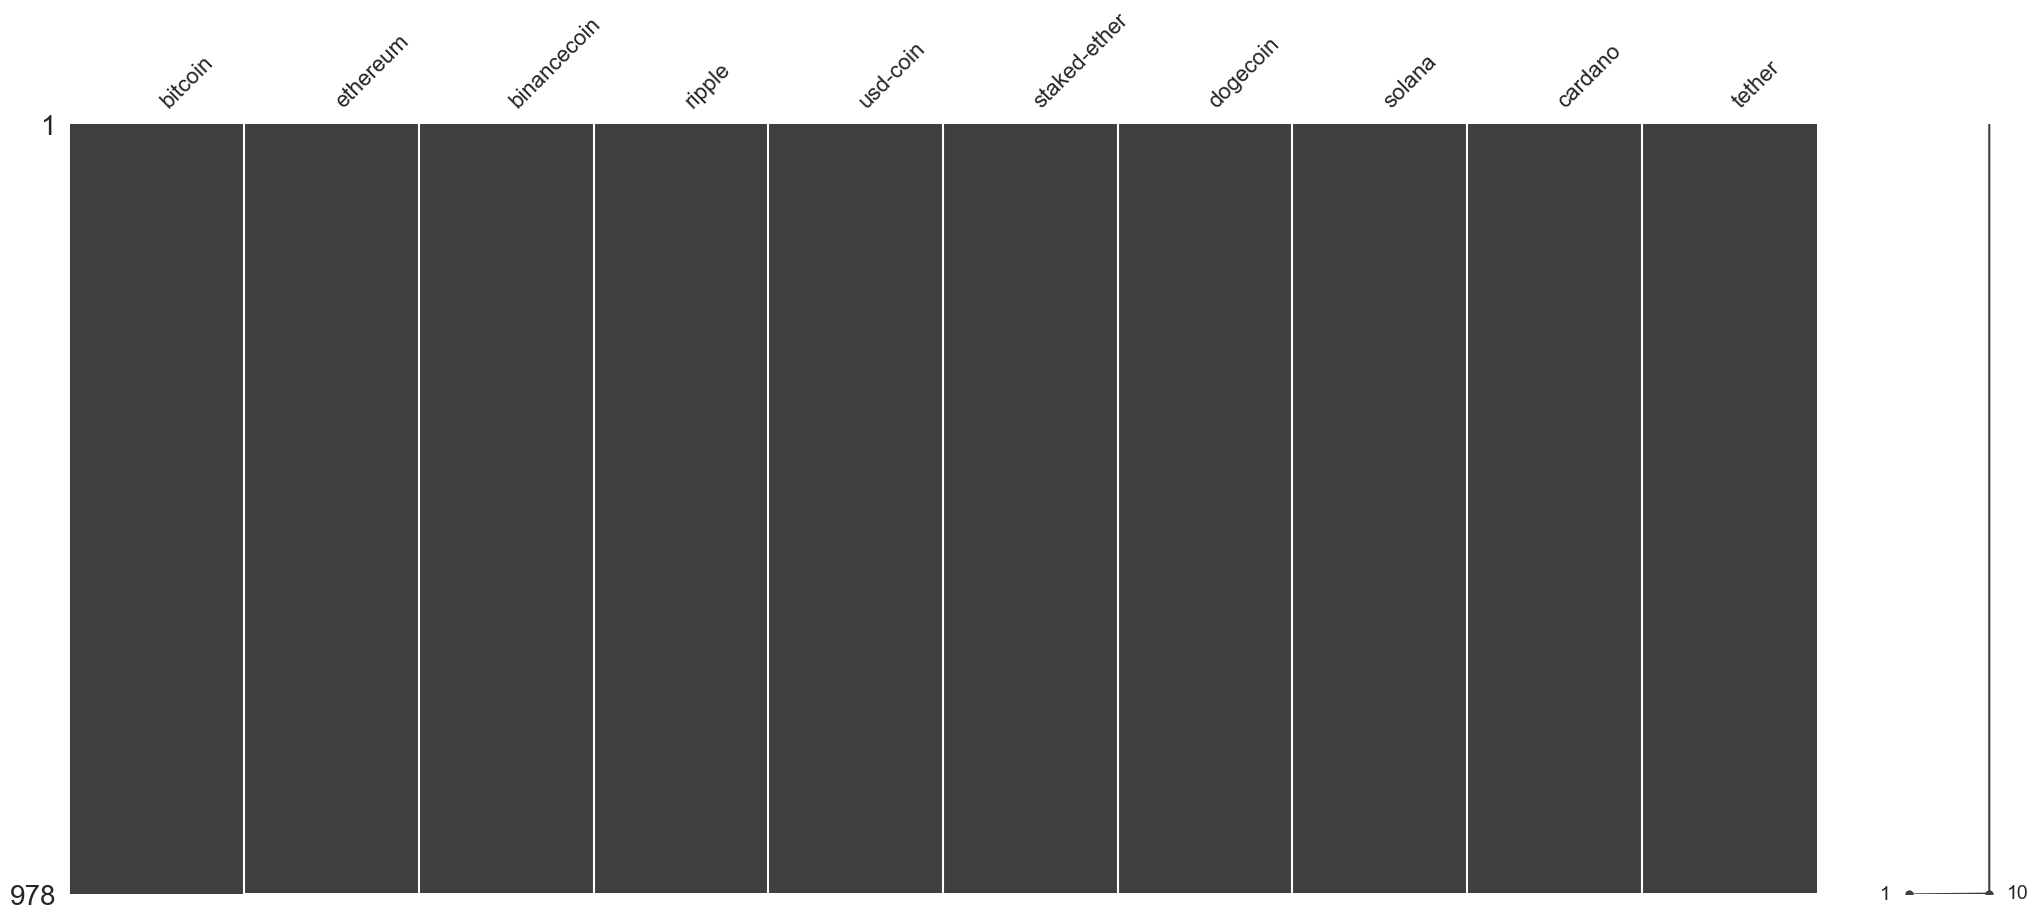

In [407]:
#chequeamos que no hayan quedado datos faltantes:
msno.matrix(df_informe)
plt.show()

<ipython-input-408-ac54f175a1e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df.index)


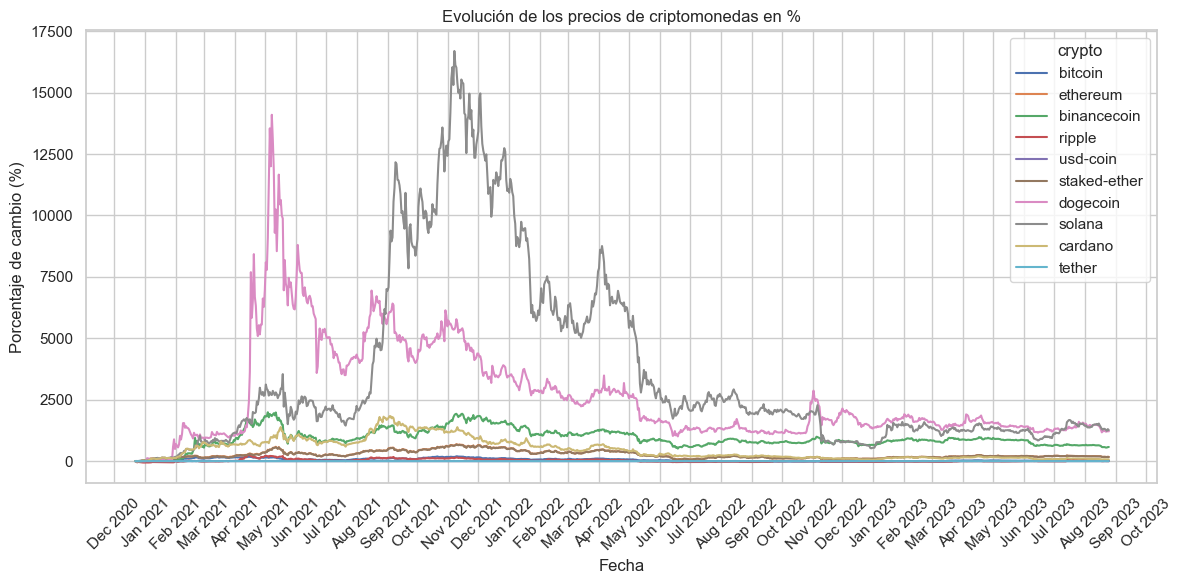

In [408]:
df = df_informe

df['time'] = pd.to_datetime(df.index)

#configuracion de valores relativos de acuerdo a valor inicial
initial_values = df.iloc[0, :-1]  # Valores iniciales de todas las criptomonedas (excepto la columna 'time')
df_percentage = df.copy()
df_percentage.iloc[:, :-1] = (df.iloc[:, :-1] / initial_values - 1) * 100

df_melted = pd.melt(df_percentage, id_vars="time", var_name='crypto', value_name='percentage')

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

ax = sns.lineplot(x='time', y='percentage', hue='crypto', data=df_melted)
plt.title('Evolución de los precios de criptomonedas en %')
plt.xlabel('Fecha')
plt.ylabel('Porcentaje de cambio (%)')

#Configuracion de eje x con meses y años
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Trazamos una matriz de correlación, para conocer la relacion entre los diferentes tokens

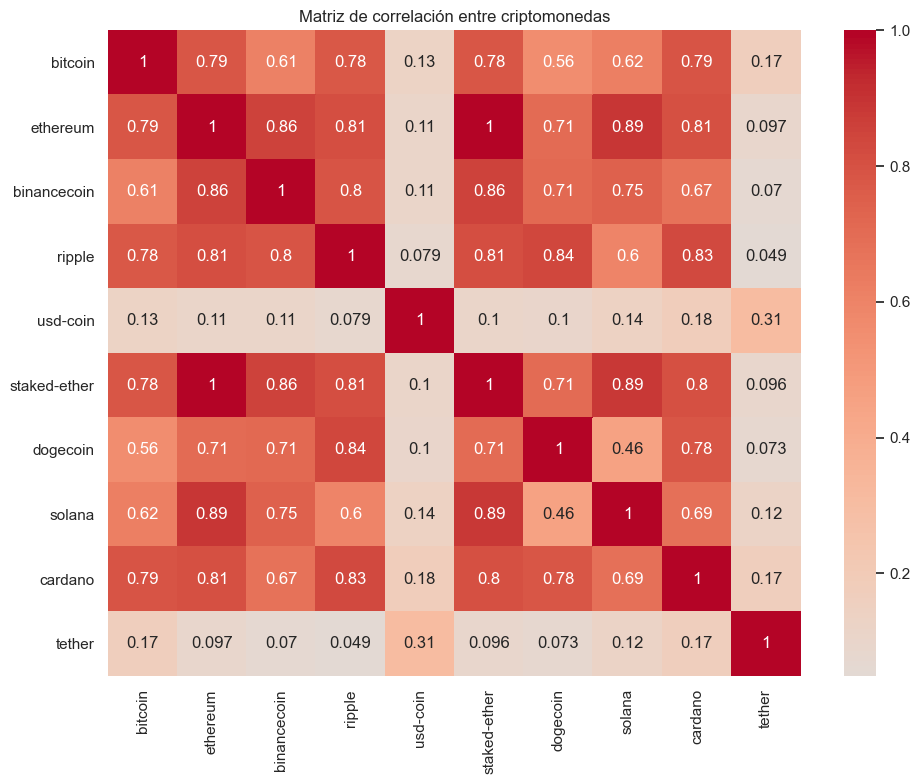

In [409]:
df = df.drop(columns=['time'])

# Calcular el porcentaje de cambio en relación al valor inicial
initial_values = df.iloc[0]  # Valores iniciales de todas las criptomonedas
df_percentage = (df / initial_values - 1) * 100

correlation_matrix = df_percentage.corr()

sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Matriz de correlación entre criptomonedas')
plt.tight_layout()
plt.show()

### Relacion entre USD-Coin y Tether
Analizamos la relación entre las monedas USD-Coin y Tether, las cuales no arroja una alta correlacion, pero ambas intentan replicar el valor del dólar. 
Se observa que ambas tuvieron sus "altibajos". Han tenido sus problemas en su composición, trato, cuestiones legales, las cuáles en determinado momento han sufrido un "de-peg" de su moneda de referencia (el dólar)

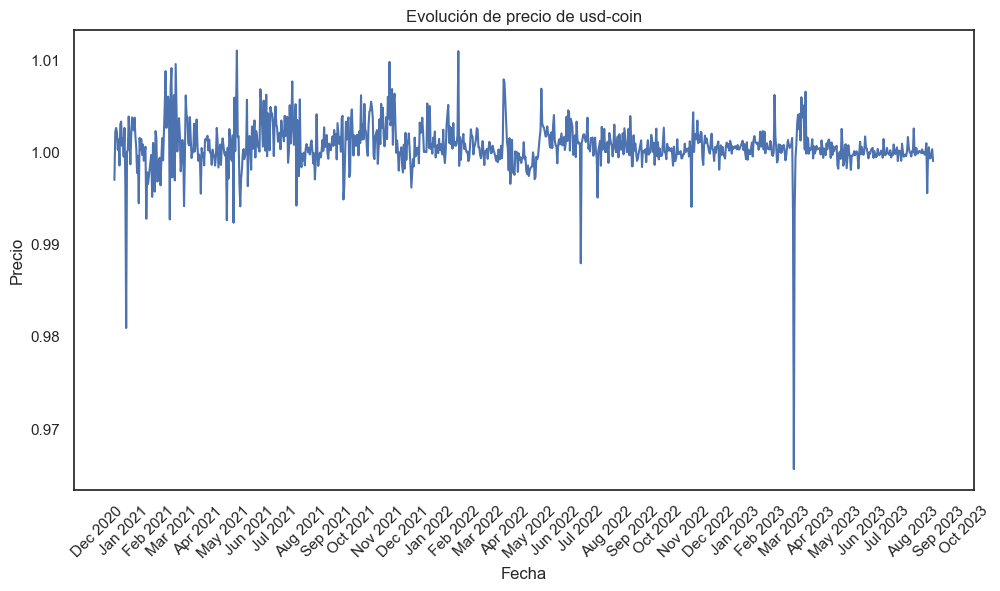

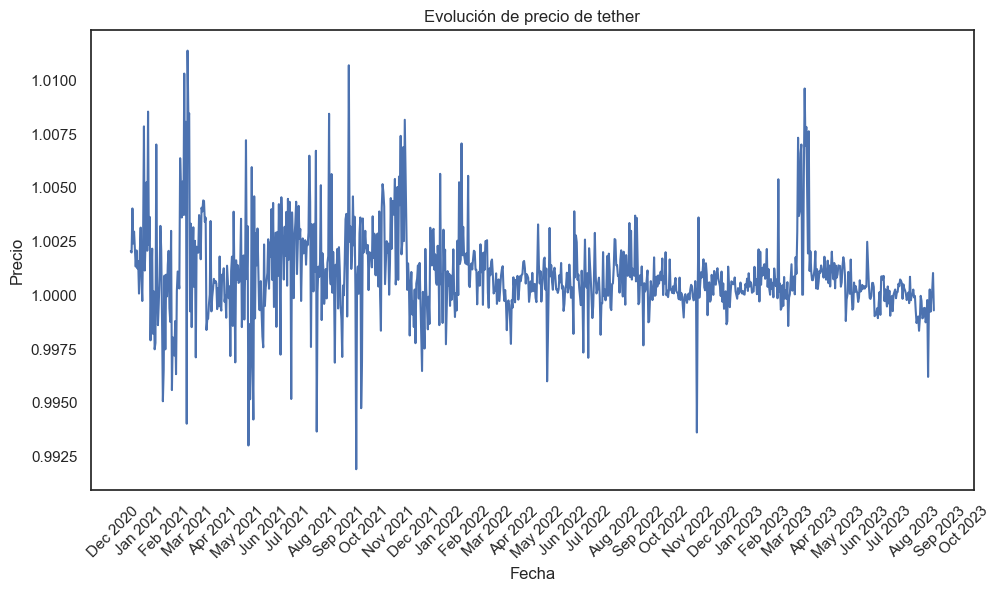

In [410]:
crypto1 = 'usd-coin'
crypto2 = 'tether'

# Asegurarse de que la columna 'time' sea del tipo datetime
df['date'] = pd.to_datetime(df.index)

# Crear gráfico individual para la primera moneda
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='date', y=crypto1, data=df)
plt.title(f'Evolución de precio de {crypto1}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.tight_layout()

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

plt.show()

# Crear gráfico individual para la segunda moneda
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='date', y=crypto2, data=df)
plt.title(f'Evolución de precio de {crypto2}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.tight_layout()

# Configurar el formato del eje x para mostrar solo los meses
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

plt.show()

### Analizamos lo que sucede entre Eth y Stacked Eth
En la matriz de correlacion pudimos ver que poseen alta correlación

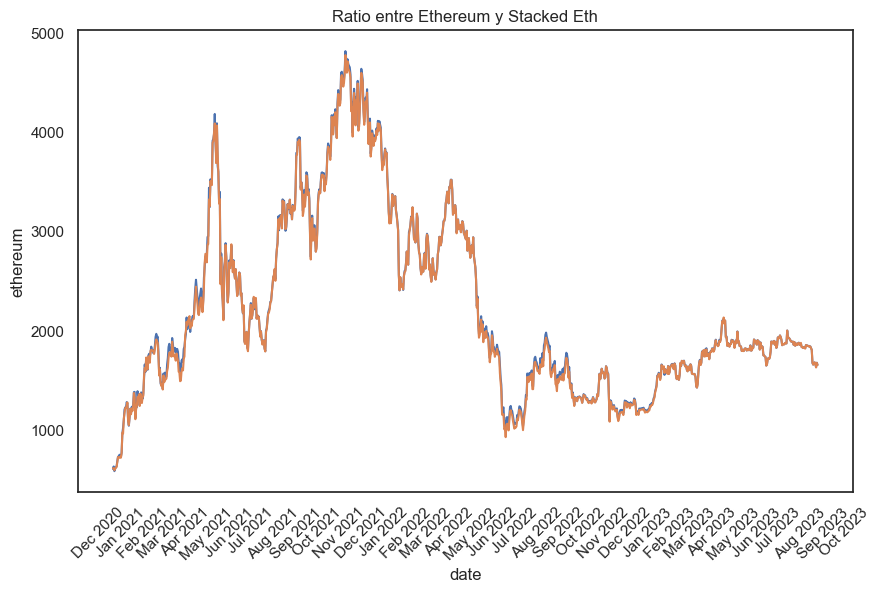

In [411]:
plt.figure(figsize=(10, 6))
plt.title('Ratio entre Ethereum y Stacked Eth')
ax = sns.lineplot(x="date", y="ethereum", data=df)
ax = sns.lineplot(x="date", y="staked-ether", data=df)
plt.xticks(rotation=45)

# Configurar el formato del eje x para mostrar solo los meses
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

plt.show()

In [412]:
dfDif = pd.DataFrame()
dfDif["ratio"] = pd.DataFrame(df["ethereum"] / df["staked-ether"])
dfDif["date"] = df.index
dfDif.head()

,ratio,date
date,,
2020-12-22,0.989082,2020-12-22
2020-12-23,1.028865,2020-12-23
2020-12-24,0.985239,2020-12-24
2020-12-25,1.002248,2020-12-25
2020-12-26,1.002651,2020-12-26


Se observa alta correlación, salvo a su inicio y momentos puntuales, pero desde Enero de 2023 que vemos no se sucedieron nuevos picos en el ratio

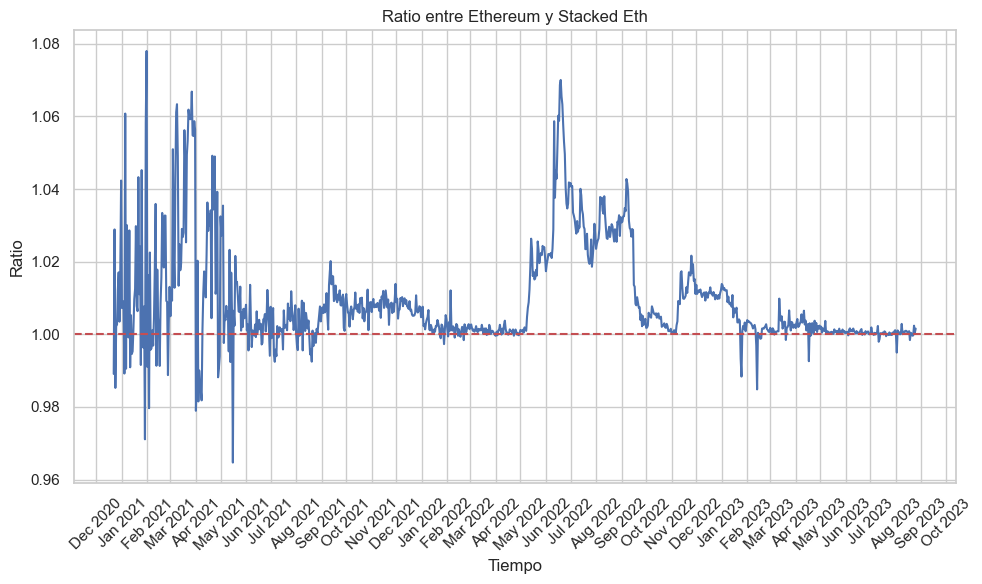

In [413]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
dfDif['date'] = pd.to_datetime(dfDif.index)
ax = sns.lineplot(x="date", y="ratio", data=dfDif)
ax.axhline(y=1, color='r', linestyle='--')
plt.title('Ratio entre Ethereum y Stacked Eth')
plt.xlabel('Tiempo')
plt.ylabel('Ratio')

# Configurar el formato del eje x para mostrar solo los meses
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dado que Stacked Ethereum tiene una altisima correlación con Ethereum, procederemos a quitar a Ethereum. Agregaremos al analisis a la siguiente con mayor market cap, Tron. Se toma dicha decisión para mantener las 10 monedas. No se toma la misma decisión con las monedas que siguen al dólar, dado que son un ancla a lo requerido por el inversor hacia una moneda dura (y diversificando específicamente el lugar donde tenemos dichos dólares). 

In [419]:
symbols = ["bitcoin", "ethereum", "binancecoin", "ripple", "usd-coin", "dogecoin", "solana", "cardano", "tether", "tron"]  

# primer moneda como punto de partida
result_df = precios(symbols[0])

# Iterar sobre los símbolos (excluyendo primera-btc) y agrega los valores dentro de las fechas existentes
for symbol in symbols[1:]:
    df = precios(symbol)
    df = df.rename(columns={"C": symbol}) 
    result_df = pd.merge(result_df, df, on="timestamp", how="left")

In [420]:
result_df['date'] = result_df['timestamp'].astype(str).str.split(' ').str[0]
result_df = result_df.set_index('date')
result_df = result_df.drop(["timestamp"], axis=1)

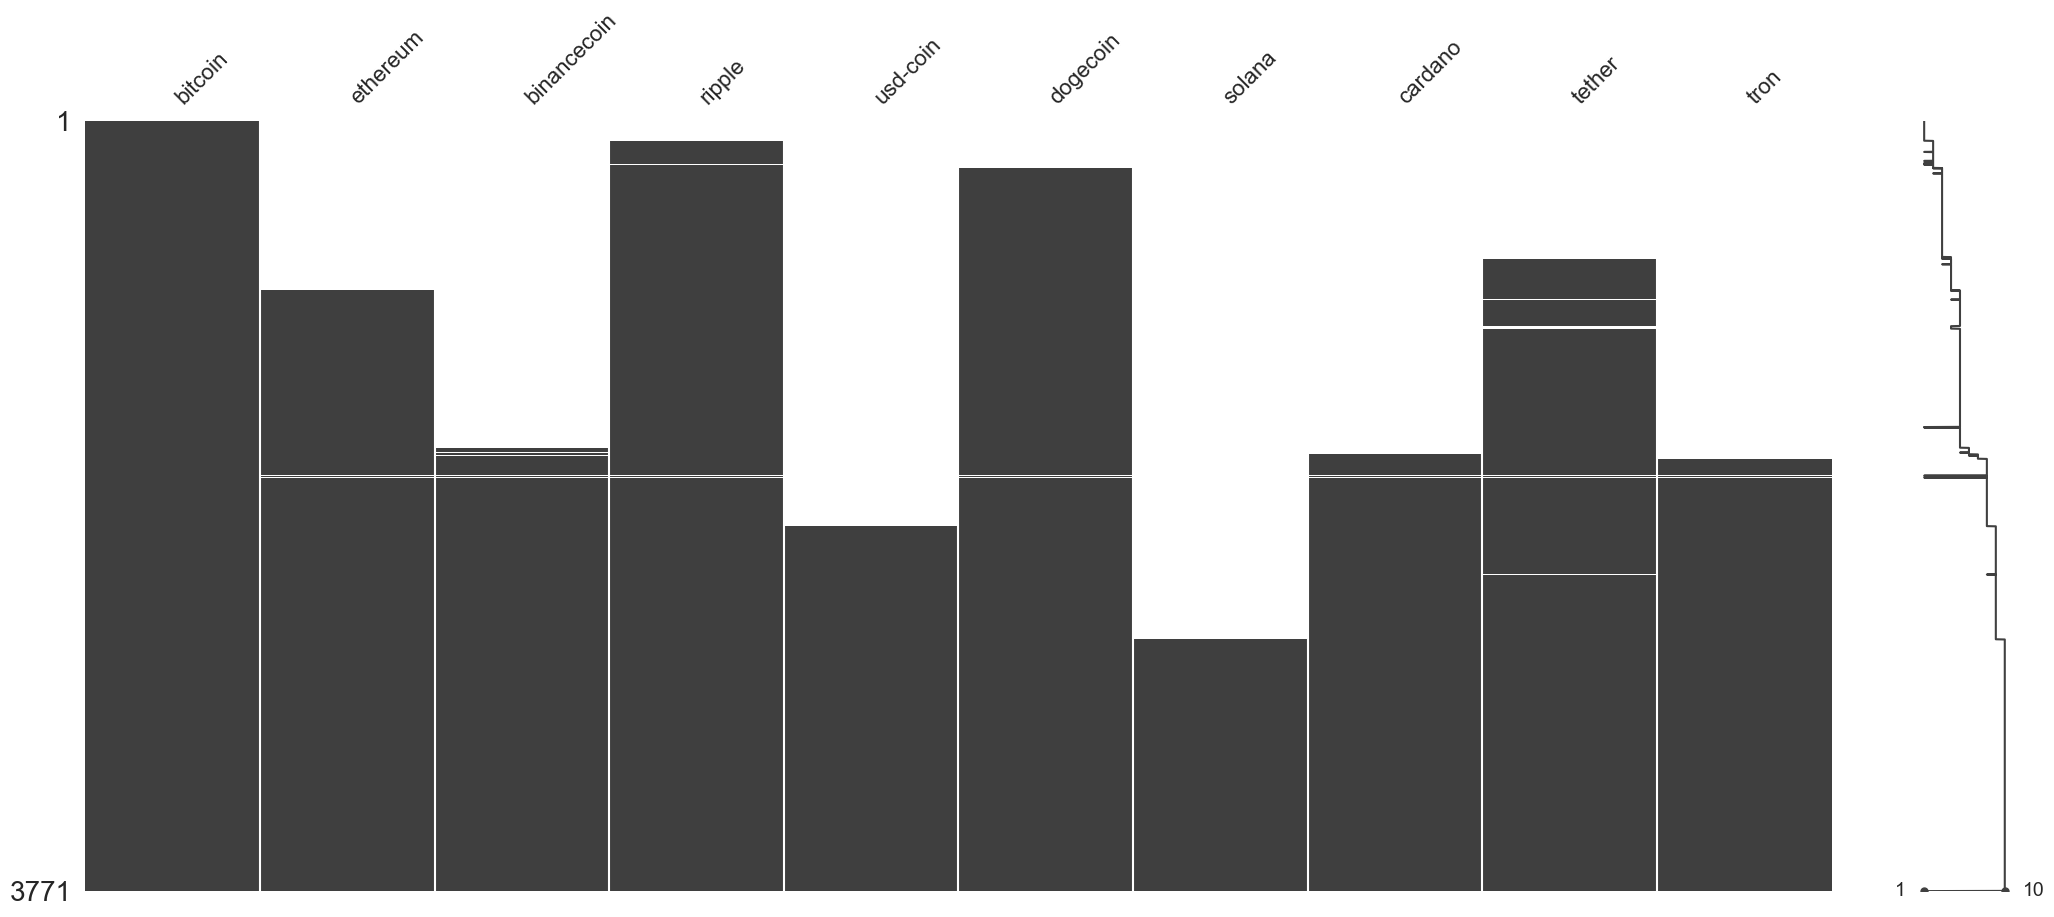

In [421]:
msno.matrix(result_df)
plt.show()

In [422]:
nan_start_index = result_df["solana"].first_valid_index()
nan_start_index

'2020-04-11'

Decidimos arrancar con valores desde el 11/04/2020

In [423]:
df_final = result_df["2020-04-11":]

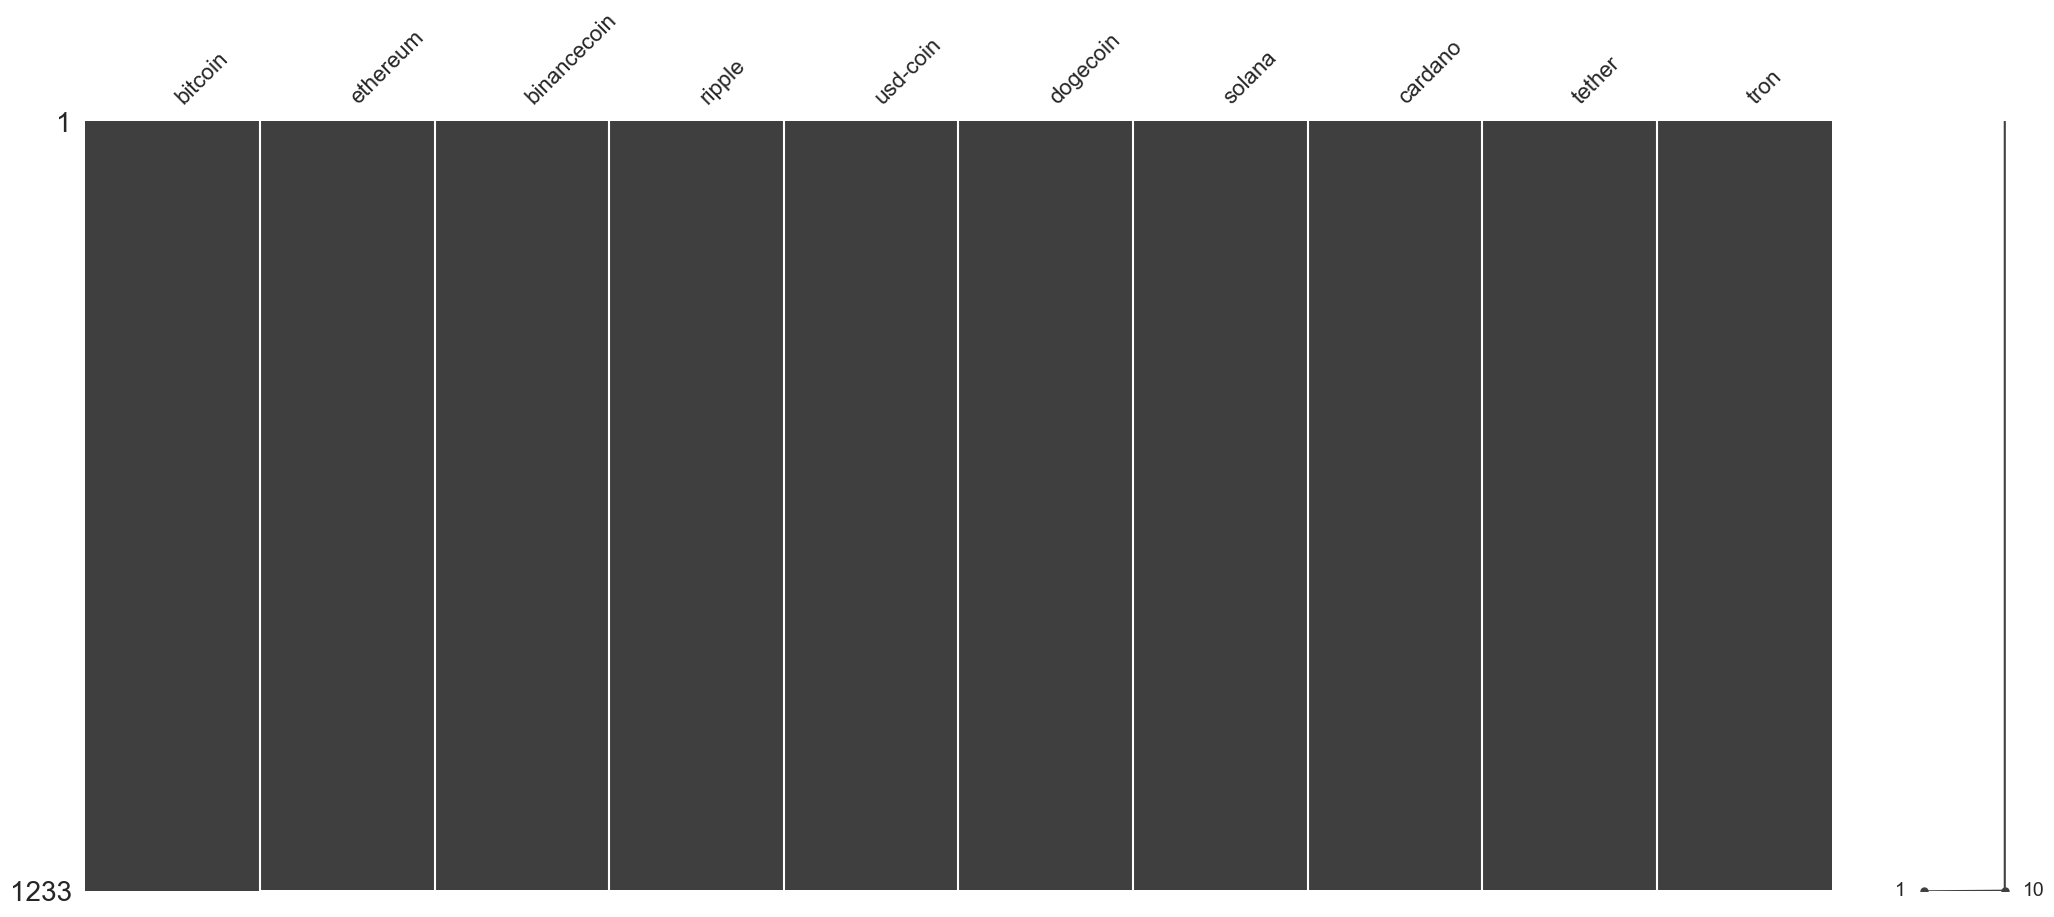

In [424]:
msno.matrix(df_final)
plt.show()

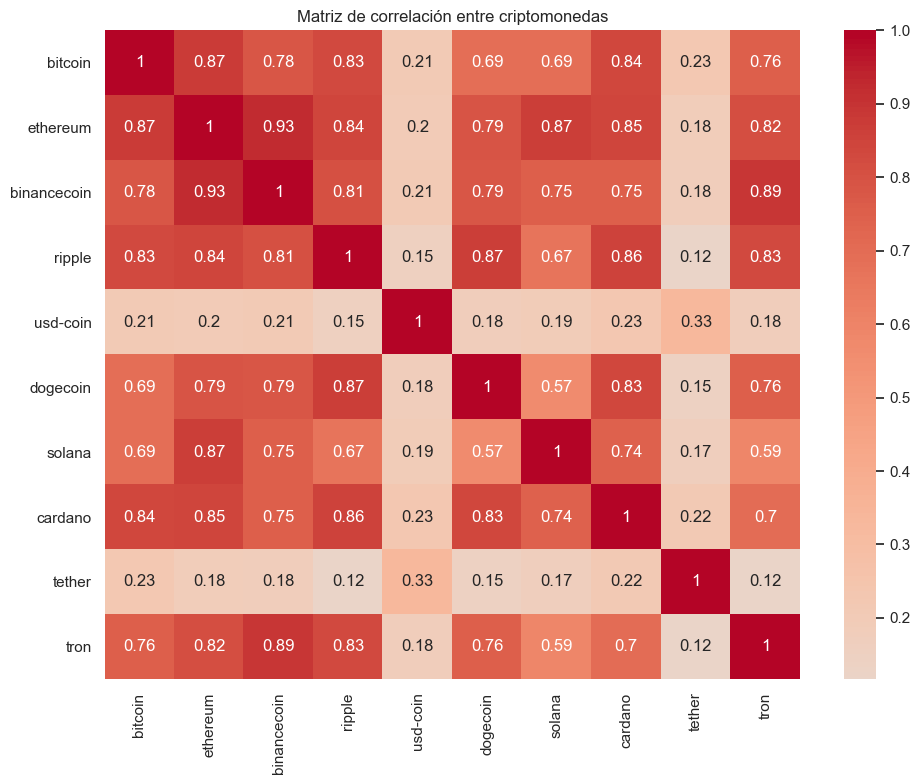

In [425]:
df = df_final

# Calcular el porcentaje de cambio en relación al valor inicial
initial_values = df.iloc[0]  # Valores iniciales de todas las criptomonedas
df_percentage = (df / initial_values - 1) * 100

# Calcular la matriz de correlación
correlation_matrix = df_percentage.corr()

# Crear el gráfico utilizando Seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Matriz de correlación entre criptomonedas')
plt.tight_layout()
plt.show()

<ipython-input-426-33bb29f059ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df_final.index)


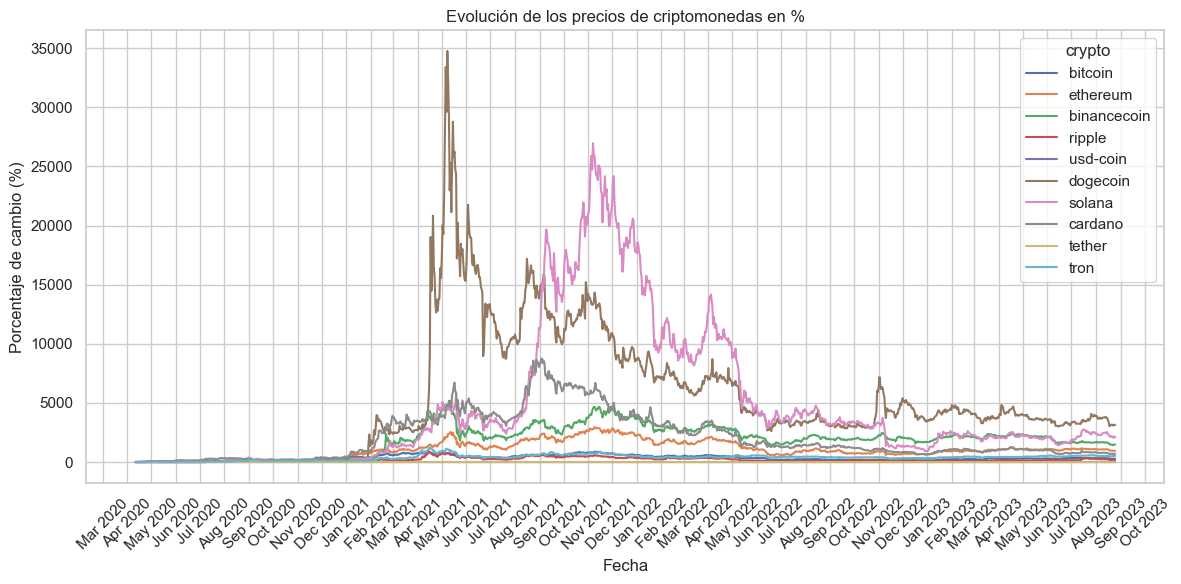

In [426]:
from matplotlib.dates import MonthLocator, DateFormatter

df = df_final

df['time'] = pd.to_datetime(df_final.index)

initial_values = df.iloc[0, :-1]  # Valores iniciales de todas las criptomonedas (excepto la columna 'time')
df_percentage = df.copy()
df_percentage.iloc[:, :-1] = (df.iloc[:, :-1] / initial_values - 1) * 100

df_melted = pd.melt(df_percentage, id_vars="time", var_name='crypto', value_name='percentage')

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

ax = sns.lineplot(x='time', y='percentage', hue='crypto', data=df_melted)
plt.title('Evolución de los precios de criptomonedas en %')
plt.xlabel('Fecha')
plt.ylabel('Porcentaje de cambio (%)')

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comenzamos a Analizar la diversificacion de Cartera segun Markowitz

In [427]:
df_final = df_final.drop("time", axis=1)

Calculamos los rendimientos de las filas (logaritmicos)

In [428]:
import numpy as np 

rportafolio = []
sdportafolio = []
pesosportafolio = []

#rendimientos = (df_final - df_final.shift(1)) / df_final.shift(1)
rendimientos = np.log(df_final / df_final.shift(1))

Realizaremos 5000 simulaciones de pesos de cada uno de los activos dentro de la cartera de inversión, para conocer sus rendimientos, desviaciones std.

In [429]:
import numpy as np

numero_activos = len(rendimientos.columns)
numero_activos

q = 5000

for x in range(q):
    pesos = np.random.random(numero_activos)
    pesos /= np.sum(pesos)
    pesosportafolio.append(pesos)
    rportafolio.append(np.dot(rendimientos.mean(), pesos))
    sdportafolio.append(np.dot(pesos.T, np.dot(rendimientos.cov(), pesos)))

In [430]:
#rportafolio

In [431]:
#sdportafolio

In [432]:
#pesosportafolio

In [433]:
diccionario = {"Rendimientos":rportafolio, "Volatilidad":sdportafolio}
for contador, ticker in enumerate(rendimientos.columns.tolist()):
    diccionario["Peso Relativo -" + ticker] = [w[contador] for w in pesosportafolio]

In [434]:
matrizportafolio = pd.DataFrame(diccionario)

Calculamos el ratio Sharpe en cada una de las relaciones, para conocer cuál puede ser la mejor decisión de todas

In [435]:
matrizportafolio["sharpe_ratio"] = matrizportafolio["Rendimientos"] / matrizportafolio["Volatilidad"]
matrizportafolio.head()

,Rendimientos,Volatilidad,Peso Relativo -bitcoin,Peso Relativo -ethereum,Peso Relativo -binancecoin,Peso Relativo -ripple,Peso Relativo -usd-coin,Peso Relativo -dogecoin,Peso Relativo -solana,Peso Relativo -cardano,Peso Relativo -tether,Peso Relativo -tron,sharpe_ratio
0,0.001642,0.001333,0.010337,0.135883,0.106222,0.053267,0.042329,0.134290,0.067345,0.200674,0.111460,0.138194,1.231548
1,0.001500,0.001053,0.180974,0.201725,0.129177,0.017317,0.121292,0.067597,0.083254,0.071823,0.062554,0.064287,1.424148
2,0.001225,0.001079,0.059450,0.008634,0.025783,0.187241,0.188114,0.216285,0.025626,0.125039,0.130811,0.033017,1.135435
3,0.001617,0.001350,0.146385,0.142088,0.035539,0.054573,0.119225,0.106771,0.157590,0.105622,0.004073,0.128133,1.197234
4,0.001234,0.001119,0.058582,0.153181,0.185121,0.257730,0.016500,0.006103,0.067866,0.035438,0.217246,0.002234,1.102225


Trazamos la Frontera Eficiente. Donde tenemos el mayor rendimiento para una volatilidad dada (parte superior de la curva)

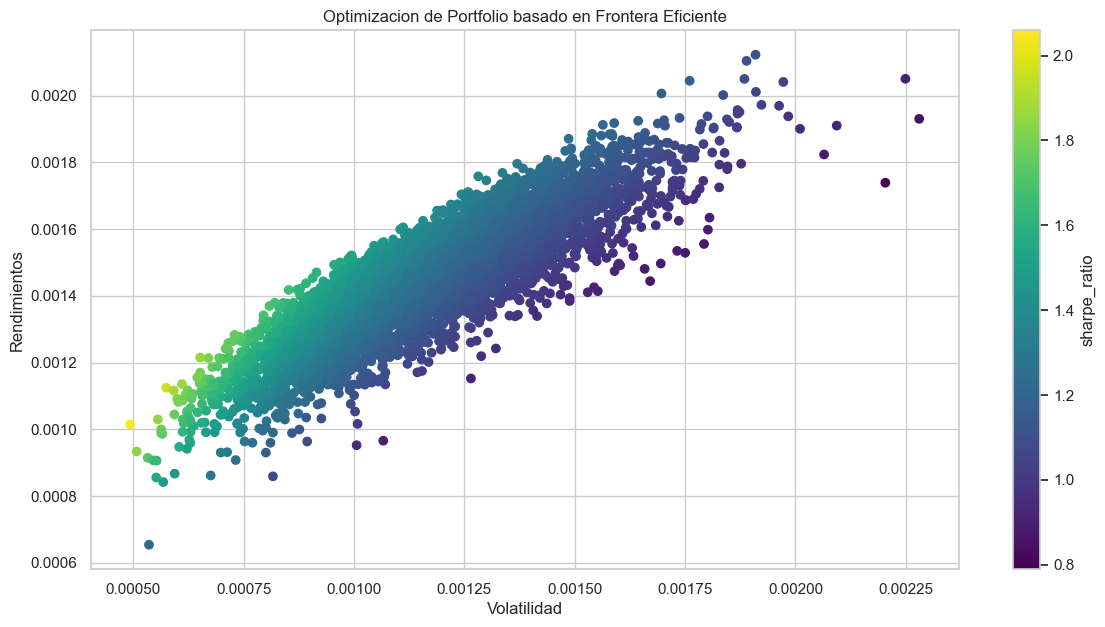

In [436]:
#Frontera eficiente
plt.figure(figsize=(14,7))
plt.scatter(x=matrizportafolio["Volatilidad"], y=matrizportafolio["Rendimientos"], c=matrizportafolio["sharpe_ratio"], cmap='viridis')
plt.colorbar(label="sharpe_ratio")
plt.title("Optimizacion de Portfolio basado en Frontera Eficiente")
plt.ylabel("Rendimientos")
plt.xlabel("Volatilidad")
plt.show()

### Carteras...
Entre todos los portafolios, cual tiene la menor volatilidad?

In [437]:
varianzaminima = matrizportafolio.iloc[matrizportafolio["Volatilidad"].idxmin()]
varianzaminima    

Rendimientos                  0.001014
Volatilidad                   0.000493
Peso Relativo -bitcoin        0.032456
Peso Relativo -ethereum       0.051934
Peso Relativo -binancecoin    0.084164
Peso Relativo -ripple         0.017680
Peso Relativo -usd-coin       0.242475
Peso Relativo -dogecoin       0.090062
Peso Relativo -solana         0.036436
Peso Relativo -cardano        0.082452
Peso Relativo -tether         0.231146
Peso Relativo -tron           0.131195
sharpe_ratio                  2.059545
Name: 4700, dtype: float64

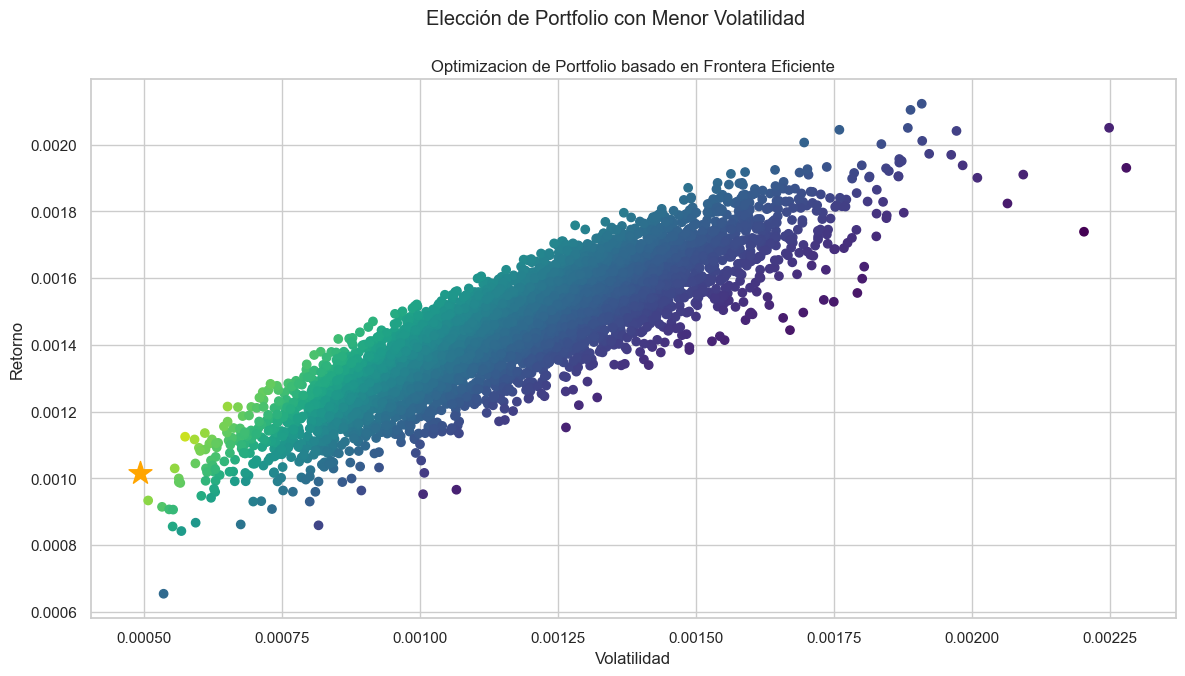

In [438]:
plt.figure(figsize=(14,7))
plt.scatter(x=matrizportafolio["Volatilidad"], y=matrizportafolio["Rendimientos"], c=matrizportafolio["sharpe_ratio"], cmap='viridis')
plt.scatter(x = varianzaminima[1], y = varianzaminima[0], color = "orange", marker = "*", s=300)
plt.title("Optimizacion de Portfolio basado en Frontera Eficiente")
plt.suptitle("Elección de Portfolio con Menor Volatilidad")
plt.xlabel('Volatilidad')
plt.ylabel('Retorno')
plt.show()

Y cual es la mejor cartera? Aquella que posea la mayor relación entre Rendimiento o Retorno y Volatilidad o Varianza

In [439]:
print("máximo Sharpe: {}".format(matrizportafolio["sharpe_ratio"].max()))
print("localización de índice máximo: {}".format(matrizportafolio["sharpe_ratio"].argmax()))

máximo Sharpe: 2.0595448839318773
localización de índice máximo: 4700


Datos de la matriz en el punto máximo... Pesos y Datos

In [440]:
matrizportafolio.loc[matrizportafolio["sharpe_ratio"].argmax(),]

Rendimientos                  0.001014
Volatilidad                   0.000493
Peso Relativo -bitcoin        0.032456
Peso Relativo -ethereum       0.051934
Peso Relativo -binancecoin    0.084164
Peso Relativo -ripple         0.017680
Peso Relativo -usd-coin       0.242475
Peso Relativo -dogecoin       0.090062
Peso Relativo -solana         0.036436
Peso Relativo -cardano        0.082452
Peso Relativo -tether         0.231146
Peso Relativo -tron           0.131195
sharpe_ratio                  2.059545
Name: 4700, dtype: float64

In [441]:
maxrend = matrizportafolio["Rendimientos"].loc[matrizportafolio["sharpe_ratio"].argmax(),]
maxvol = matrizportafolio["Volatilidad"].loc[matrizportafolio["sharpe_ratio"].argmax(),]

La estrella roja marca el punto con mejor valor de ratio Sharpe

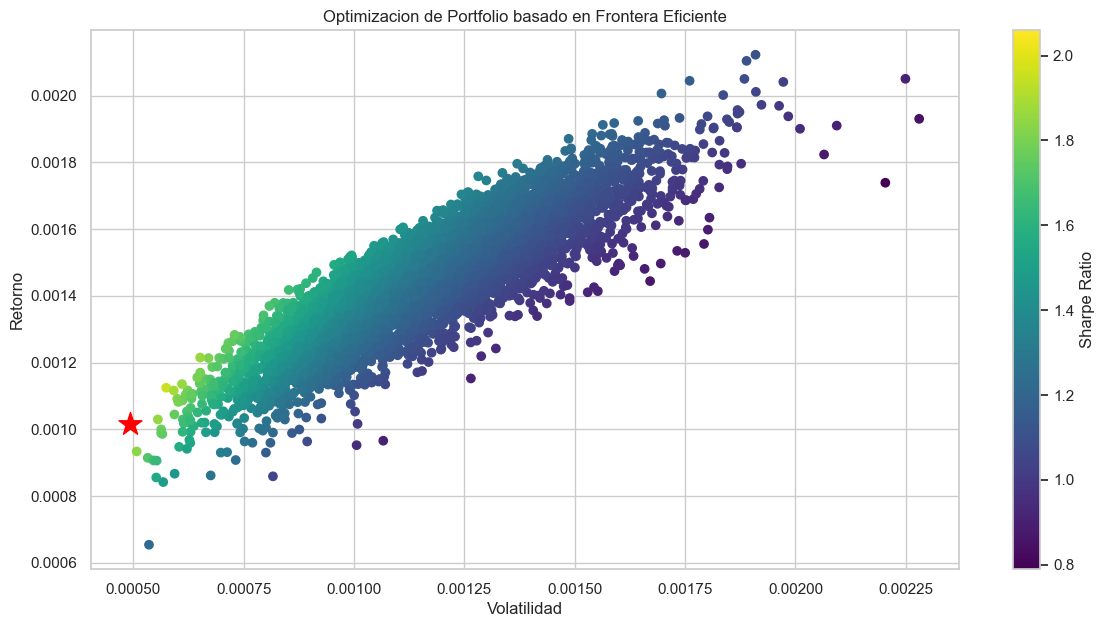

In [442]:
plt.figure(figsize=(14,7))
plt.scatter(x=matrizportafolio["Volatilidad"], y=matrizportafolio["Rendimientos"], c=matrizportafolio["sharpe_ratio"], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.title("Optimizacion de Portfolio basado en Frontera Eficiente")
plt.xlabel('Volatilidad')
plt.ylabel('Retorno')
plt.scatter(x = maxvol, y = maxrend, color = "red", marker = "*", s=300)
plt.show()

### Cartera Propuesta
Aqui vemos la distribución de pesos de la cartera que mejor ratio nos ofrece. 

<Figure size 1400x700 with 0 Axes>

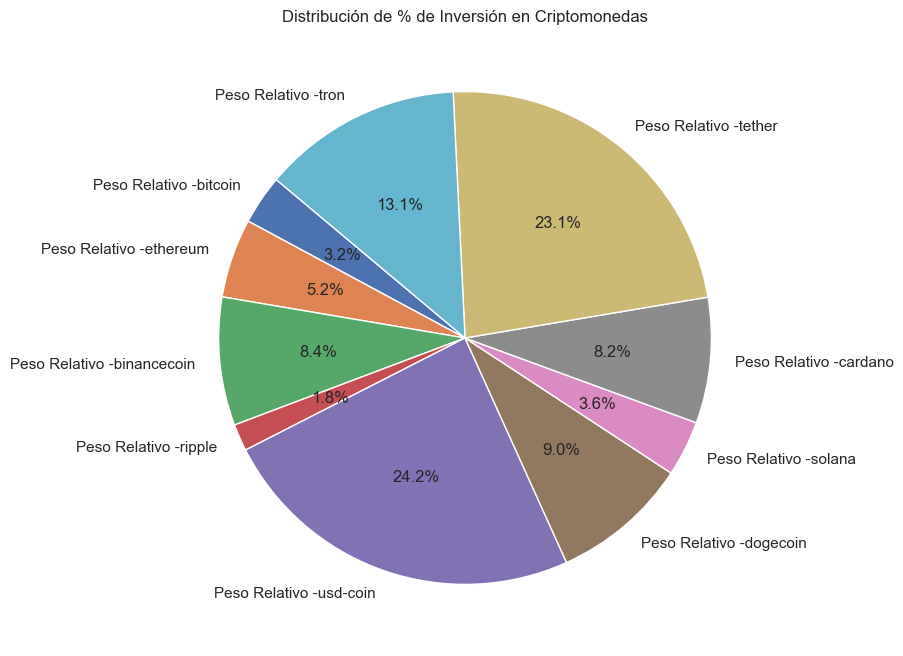

In [443]:
plt.figure(figsize=(14,7))
optimo = matrizportafolio.loc[matrizportafolio["sharpe_ratio"].argmax()]
optimochart = optimo.drop(["Rendimientos", "Volatilidad", "sharpe_ratio"], axis=0)
optimochart = pd.DataFrame(optimochart)
optimochart = optimochart.T

plt.figure(figsize=(8, 8))
plt.pie(optimochart.iloc[0,:], labels=optimochart.columns, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de % de Inversión en Criptomonedas')
plt.show()

In [444]:
rendimientos

,bitcoin,ethereum,binancecoin,ripple,usd-coin,dogecoin,solana,cardano,tether,tron
date,,,,,,,,,,
2020-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-12,0.002050,0.003719,0.007837,0.000832,0.000338,0.019861,-0.199120,-0.006374,-0.000338,-0.000319
2020-04-13,0.004985,0.003379,0.031211,-0.003461,-0.003027,-0.009554,0.110044,0.004940,-0.005334,0.016534
2020-04-14,-0.008078,-0.013706,0.053267,0.001798,0.001788,-0.008149,-0.107497,-0.010147,0.002893,-0.010436
2020-04-15,0.000385,0.009943,0.035079,-0.011558,0.001352,0.003676,-0.165562,-0.002323,0.001650,-0.012542
...,...,...,...,...,...,...,...,...,...,...
2023-08-22,-0.001595,-0.009328,-0.026486,-0.027509,0.000024,-0.019686,-0.025400,-0.027626,0.000625,-0.008313
2023-08-23,-0.003272,-0.019170,0.001187,-0.006662,0.000479,0.001241,-0.031050,-0.017495,0.000367,0.004786
2023-08-24,0.015866,0.026512,0.026357,0.017122,0.000495,0.019695,0.052997,0.037565,0.000808,0.027730


### Comportamiento de la inversión, si manteníamos de manera proporcional entre las 10 monedas

In [514]:
crypto_columns = df_percentage.columns[:-1]
dfProporcional = df_percentage.copy()
dfProporcional['Total_Rendimiento'] = df_percentage[crypto_columns].sum(axis=1) /10

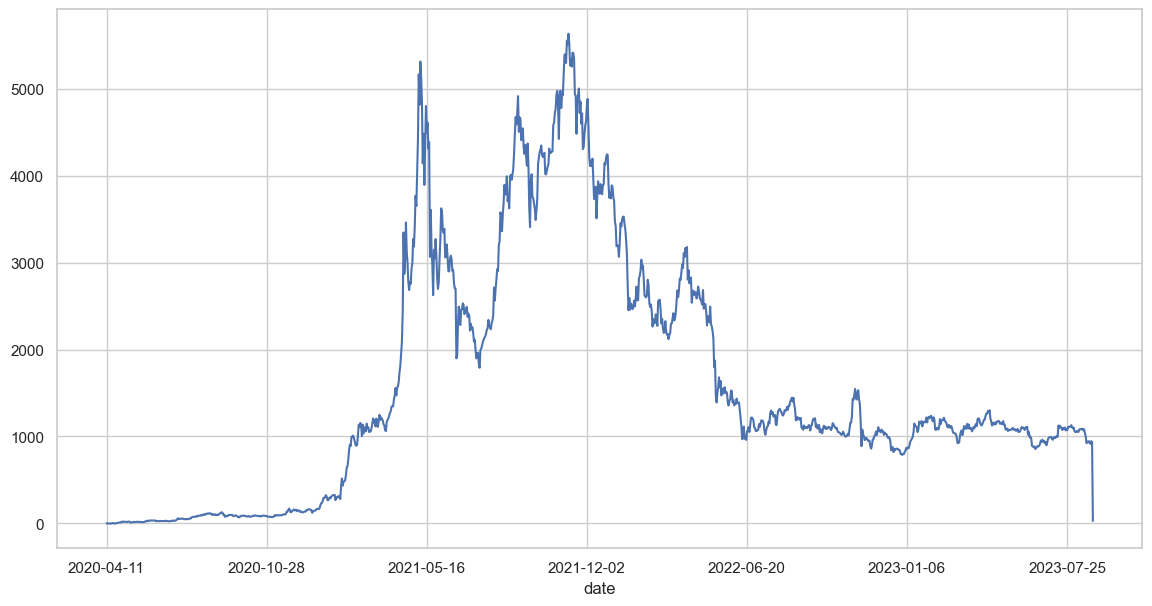

In [515]:
plt.figure(figsize=(14,7))
dfProporcional["Total_Rendimiento"].plot()
plt.show()

In [516]:
crypto_columns = df_percentage.columns[:-1]
weights = [0.032456, 0.051934, 0.084164, 0.017680, 0.242475, 0.090062, 0.036436, 0.082452, 0.231146, 0.131195]  # Porcentajes de peso relativos para cada moneda

dfPesos = df_percentage.copy()

# Multiplica cada columna por su peso correspondiente
dfPesos[crypto_columns] = dfPesos[crypto_columns].mul(weights)

# Calcula el rendimiento total sumando los valores en todas las columnas
dfPesos['Total_Rendimiento'] = dfPesos[crypto_columns].sum(axis=1)

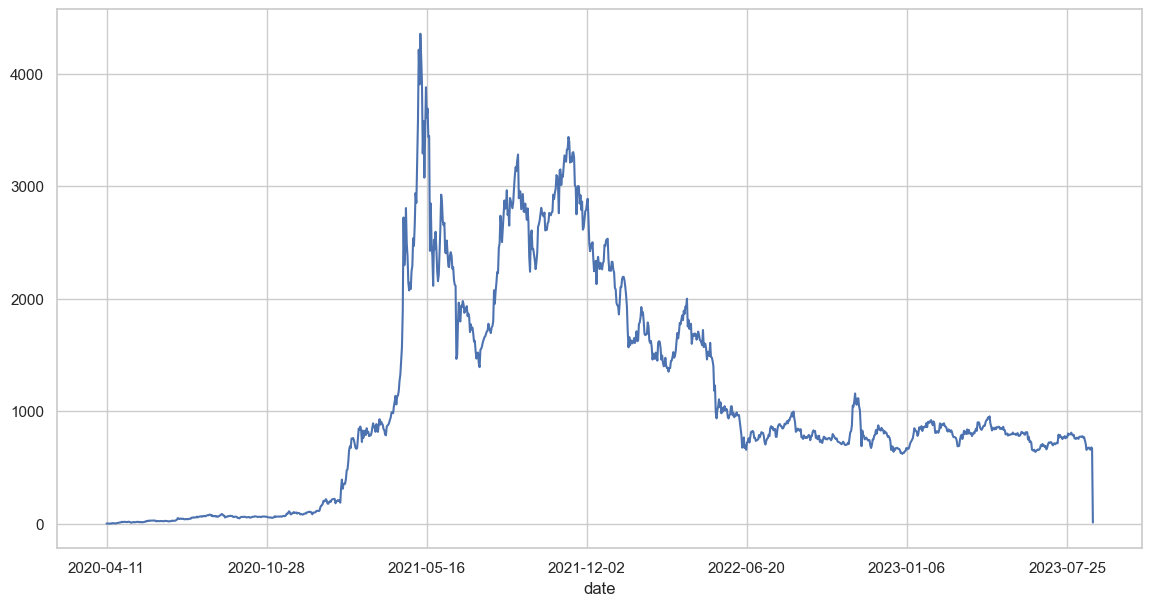

In [517]:
plt.figure(figsize=(14,7))
dfPesos["Total_Rendimiento"].plot()
plt.show()

In [518]:
### Comparamos los 2 gráficos y rendimientos

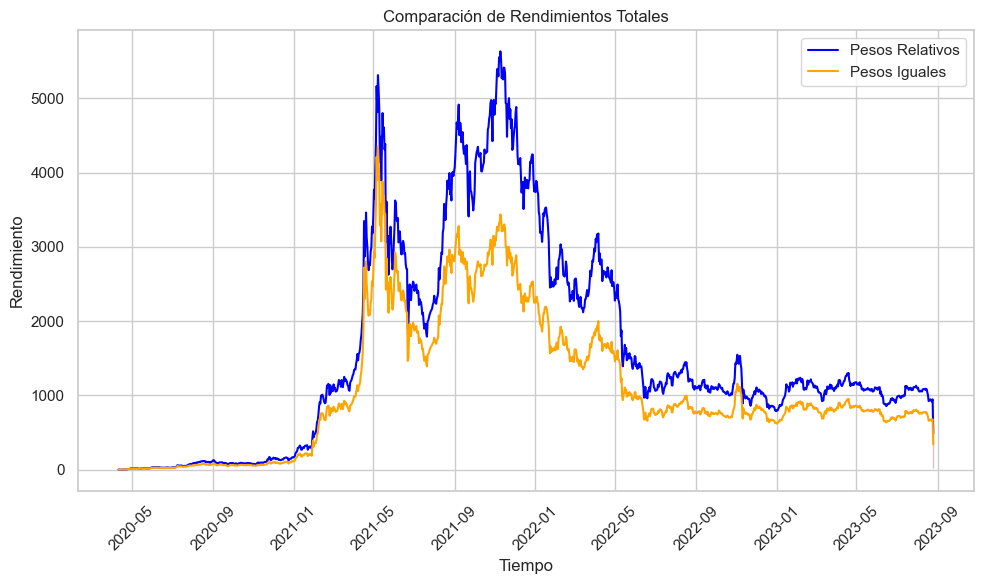

In [519]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=dfProporcional, x='time', y='Total_Rendimiento', label='Pesos Relativos', color='blue')

sns.lineplot(data=dfPesos, x='time', y='Total_Rendimiento', label='Pesos Iguales', color='orange')

plt.title('Comparación de Rendimientos Totales')
plt.xlabel('Tiempo')
plt.ylabel('Rendimiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

### Obtenemos KPIs

In [520]:
rendimiento_final_proporcional = dfProporcional.iloc[-2]['Total_Rendimiento']
rendimiento_final_proporcional

931.8979546577132

In [521]:
rendimiento_final_pesos = dfPesos.iloc[-2]['Total_Rendimiento']
rendimiento_final_pesos

668.7440283423819

In [530]:
volatilidad_criptomonedas = dfPesos["Total_Rendimiento"].std()

# Calcular la volatilidad total del portafolio
volatilidad_total = np.sqrt(np.sum(np.square(volatilidad_criptomonedas)))

print("\nVolatilidad total del portafolio de Pesos Relativos:")
print(volatilidad_total)


Volatilidad total del portafolio de Pesos Relativos:
922.1961783676126


In [532]:
volatilidad_criptomonedas = dfProporcional["Total_Rendimiento"].std()

# Calcular la volatilidad total del portafolio
volatilidad_total = np.sqrt(np.sum(np.square(volatilidad_criptomonedas)))

print("\nVolatilidad total del portafolio Proporcional:")
print(volatilidad_total)


Volatilidad total del portafolio Proporcional:
1385.0494844958425
